
# Rare Event Resampling Experiments

This notebook contains a series of controlled experiments designed to evaluate different resampling strategies for rare event prediction using Elastic Net Logistic Regression. All experiments use the same base data preprocessing and modeling pipeline, and differ only in their choice of resampling technique.


In [1]:

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# 2. Load and Preprocess
df = pd.read_csv("synth_rare_event_data.csv")
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
target_col = "rare_event"
df = df.dropna(subset=[target_col])
X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Standardize
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Feature Selection
mi = mutual_info_classif(X, y)
top_features = pd.Series(mi, index=X.columns).sort_values(ascending=False).head(15).index.tolist()
X = X[top_features]

# Train-Test Split (before any resampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define a model for consistency
def make_model():
    return LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000,
                              class_weight='balanced', random_state=42)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()


## 1. Manual Upsampling

In [4]:
# 1. Manual Upsampling (Fixed Index Alignment)
from sklearn.utils import resample

# Reset index to ensure clean concat
X_train_reset = X_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# Combine features and labels into one DataFrame
train_df = pd.concat([X_train_reset, y_train_reset], axis=1)

# Split into classes
minority = train_df[train_df[target_col] == 1]
majority = train_df[train_df[target_col] == 0]

# Upsample minority class
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=42
)

# Combine the upsampled data
upsampled_train = pd.concat([majority, minority_upsampled])

# Separate features and target again
X_train = upsampled_train.drop(columns=[target_col])
y_train = upsampled_train[target_col]

              precision    recall  f1-score   support

           0       0.98      0.58      0.73       982
           1       0.02      0.39      0.03        18

    accuracy                           0.57      1000
   macro avg       0.50      0.48      0.38      1000
weighted avg       0.96      0.57      0.72      1000

ROC AUC: 0.4922493776872595


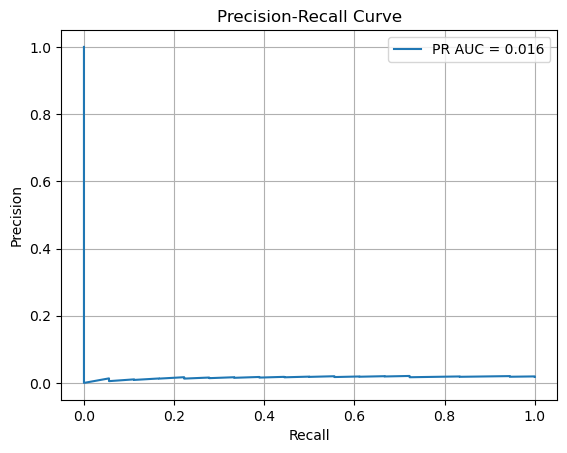

In [6]:
# 2. Train and Evaluate
model = make_model()
model.fit(X_train, y_train)
evaluate_model(model, X_test, y_test)

## 2. SMOTE

              precision    recall  f1-score   support

           0       0.98      0.58      0.73       982
           1       0.01      0.28      0.02        18

    accuracy                           0.57      1000
   macro avg       0.49      0.43      0.37      1000
weighted avg       0.96      0.57      0.71      1000

ROC AUC: 0.4512898845892736


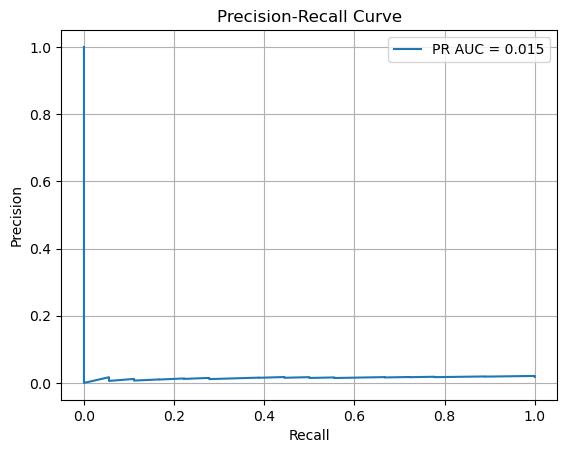

In [3]:
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_train_bal, y_train_bal)
evaluate_model(model, X_test, y_test)

## 3. SMOTE-Tomek

              precision    recall  f1-score   support

           0       0.98      0.58      0.73       982
           1       0.01      0.28      0.02        18

    accuracy                           0.57      1000
   macro avg       0.49      0.43      0.37      1000
weighted avg       0.96      0.57      0.71      1000

ROC AUC: 0.4512898845892736


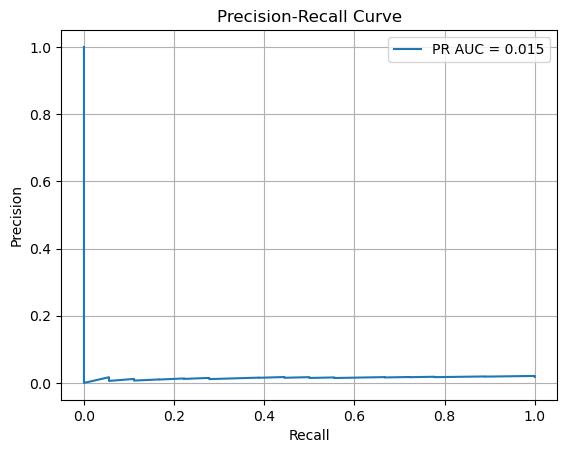

In [5]:
X_train_bal, y_train_bal = SMOTETomek(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_train_bal, y_train_bal)
evaluate_model(model, X_test, y_test)

## 4. ADASYN

              precision    recall  f1-score   support

           0       0.98      0.58      0.73       982
           1       0.01      0.28      0.02        18

    accuracy                           0.57      1000
   macro avg       0.49      0.43      0.37      1000
weighted avg       0.96      0.57      0.71      1000

ROC AUC: 0.45660782982575243


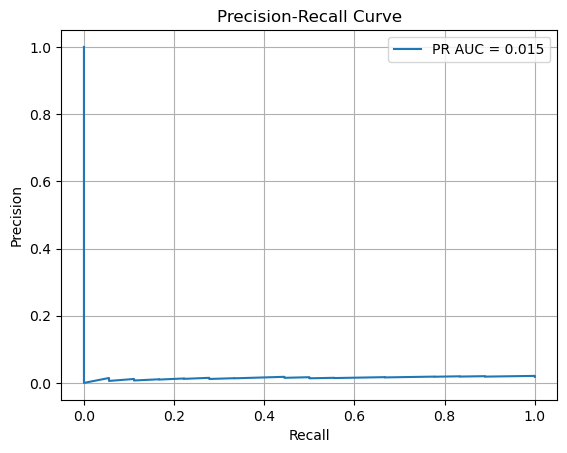

In [7]:
from imblearn.over_sampling import ADASYN
X_train_bal, y_train_bal = ADASYN(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_train_bal, y_train_bal)
evaluate_model(model, X_test, y_test)

## 5. Borderline-SMOTE

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       982
           1       0.01      0.17      0.02        18

    accuracy                           0.70      1000
   macro avg       0.49      0.44      0.42      1000
weighted avg       0.96      0.70      0.81      1000

ROC AUC: 0.5092781172210907


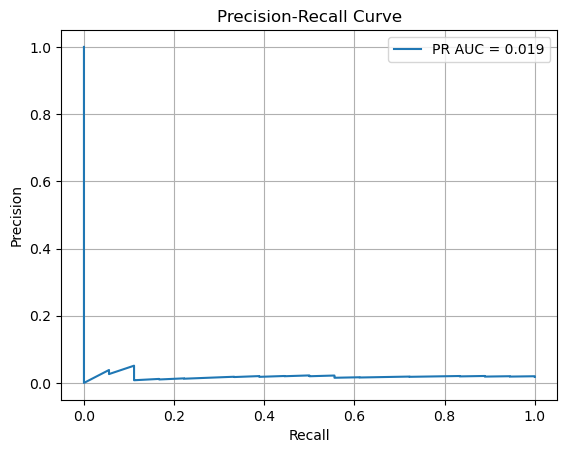

In [9]:
X_train_bal, y_train_bal = BorderlineSMOTE(random_state=42).fit_resample(X_train, y_train)
model = make_model()
model.fit(X_train_bal, y_train_bal)
evaluate_model(model, X_test, y_test)

## 6. SMOTE + Class Weight Only

              precision    recall  f1-score   support

           0       0.99      0.65      0.79       982
           1       0.03      0.56      0.05        18

    accuracy                           0.65      1000
   macro avg       0.51      0.60      0.42      1000
weighted avg       0.97      0.65      0.77      1000

ROC AUC: 0.6423964697895451


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


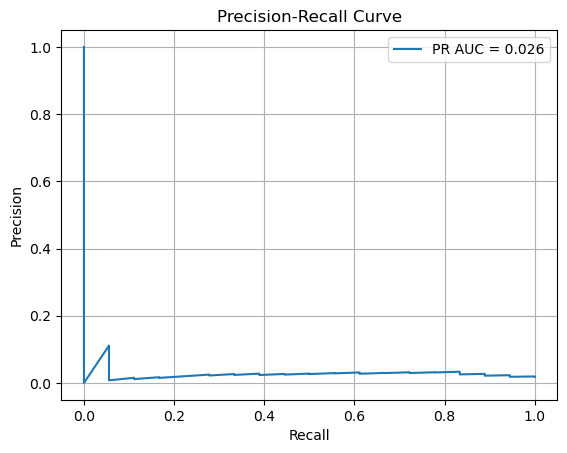

In [11]:
model = make_model()
model.fit(X_train, y_train)
evaluate_model(model, X_test, y_test)

## 7. No Resampling (Baseline)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       982
           1       0.00      0.00      0.00        18

    accuracy                           0.98      1000
   macro avg       0.49      0.50      0.50      1000
weighted avg       0.96      0.98      0.97      1000

ROC AUC: 0.47341027381760575


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

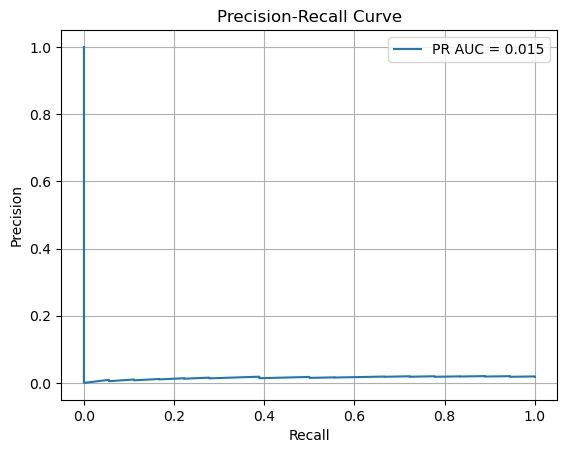

In [13]:
model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
evaluate_model(model, X_test, y_test)

## 8. Random Oversampling

In [ ]:
# use imblearn.over_sampling.RandomOverSampler

## 9. Tomek Links (Undersampling)

In [ ]:
# use imblearn.under_sampling.TomekLinks

## 10. SMOTEENN

In [ ]:
# use imblearn.combine.SMOTEENN